In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [2]:
#btc options data
df=pd.read_csv('data/btc_data_bsm.csv', sep=",", index_col=0)
df = df.reset_index(drop=False)
#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)

In [3]:
btc_data  = df

In [4]:
# Calculate gross trading profit/loss by comparing calculated BS price and market price
btc_data['gross_profit_loss'] = btc_data['Calculated_BS_Price'] - btc_data['Market Price']

# Assume management fee as a percentage of the asset's value (typically 1-2%)
management_fee_rate = 0.02  # Example: 2% management fee

# Assume incentive fee as a percentage of profit exceeding a performance threshold (typically 10-20%)
incentive_fee_rate = 0.2  # Example: 20% incentive fee
performance_threshold = 0  # Example: Incentive fee applies only if profit is positive

# Calculate management fees
btc_data['management_fee'] = btc_data['Calculated_BS_Price'] * management_fee_rate

# Calculate incentive fees (only applicable if gross profit/loss is above the performance threshold)
btc_data['incentive_fee'] = btc_data['gross_profit_loss'].apply(
    lambda x: max(0, (x - performance_threshold)) * incentive_fee_rate)

# Calculate net profit/loss after fees
btc_data['net_profit_loss'] = btc_data['gross_profit_loss'] - btc_data['management_fee'] - btc_data['incentive_fee']

# Show the head of the updated data
btc_data[['gross_profit_loss', 'management_fee', 'incentive_fee', 'net_profit_loss']].head()


,gross_profit_loss,management_fee,incentive_fee,net_profit_loss
0,4546.643138,90.932867,909.328628,3546.381644
1,4048.407698,80.968158,809.681540,3157.758001
2,4046.874602,80.937494,809.374920,3156.562187
3,3548.949295,70.978988,709.789859,2768.180448
4,3546.875256,70.937507,709.375051,2766.562697


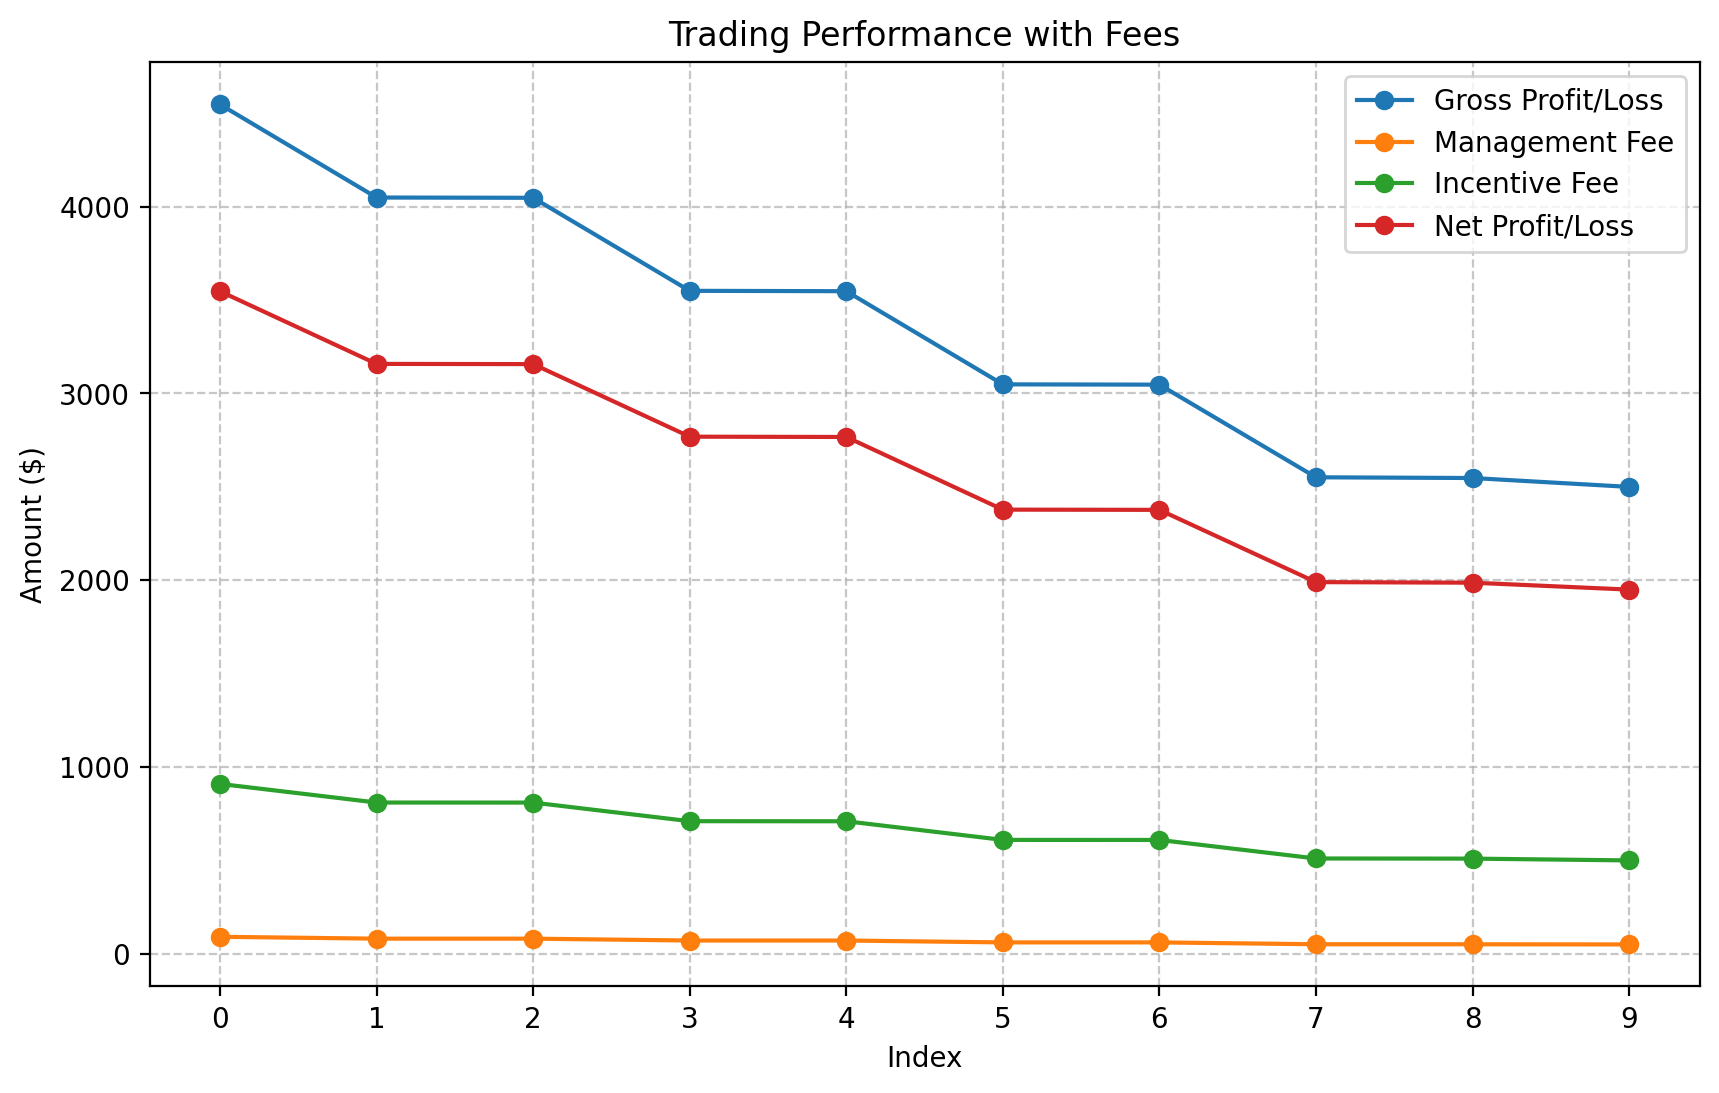

In [5]:
import matplotlib.pyplot as plt

# Select a subset of rows for plotting, or use the entire dataset if it's small
plot_data = btc_data[['gross_profit_loss', 'management_fee', 'incentive_fee', 'net_profit_loss']].head(10)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(plot_data.index, plot_data['gross_profit_loss'], label='Gross Profit/Loss', marker='o')
plt.plot(plot_data.index, plot_data['management_fee'], label='Management Fee', marker='o')
plt.plot(plot_data.index, plot_data['incentive_fee'], label='Incentive Fee', marker='o')
plt.plot(plot_data.index, plot_data['net_profit_loss'], label='Net Profit/Loss', marker='o')

# Add labels and a legend
plt.xlabel('Index')
plt.ylabel('Amount ($)')
plt.title('Trading Performance with Fees')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xticks(plot_data.index)

# Show the plot
plt.show()


In [6]:
# Assuming the Beginning Net Asset Value is known or set to an initial value
# For this calculation, we assume an arbitrary starting NAV of 1,000,000
starting_nav = 1_000_000

# Compute Ending Net Asset Value
btc_data['Ending_Net_Asset_Value'] = starting_nav + btc_data['net_profit_loss']

# Compute Monthly Rate of Return
btc_data['Monthly_Rate_of_Return'] = btc_data['net_profit_loss'] / starting_nav


# Calculate unrealized gain/loss for each position
# Using 'Optimized_BS_Price' as an approximation of the acquisition cost
btc_data['Unrealized_Gain_Loss'] = btc_data['Market Price'] - btc_data['Optimized_BS_Price']

 

# Calculate Change in Open Trade Equity:
# We will use the difference of consecutive rows in Unrealized Gain/Loss to approximate the change
btc_data['Change_in_Open_Trade_Equity'] = btc_data['Unrealized_Gain_Loss'].diff()

# Fill the first NaN with zero for the change column (beginning of data)
btc_data['Change_in_Open_Trade_Equity'].fillna(0, inplace=True)

# Calculate Net Performance w/o Fees:
btc_data['Net_Performance_wo_Fees'] = btc_data['net_profit_loss'] + btc_data['Change_in_Open_Trade_Equity']

# Calculate Net Performance using the correct column names
btc_data['Net_Performance'] = btc_data['Net_Performance_wo_Fees'] - (
    btc_data['incentive_fee'] + btc_data['management_fee']
)





# Calculate changes in NAV
btc_data['Additions_Withdrawals'] = (
    btc_data['Ending_Net_Asset_Value'] - starting_nav - btc_data['Net_Performance']
)

# Separate additions (positive values) and withdrawals (negative values)
btc_data['Additions'] = btc_data['Additions_Withdrawals'].apply(lambda x: x if x > 0 else 0)
btc_data['Withdrawals'] = btc_data['Additions_Withdrawals'].apply(lambda x: -x if x < 0 else 0)


# Calculate VAMI
btc_data['VAMI'] = starting_nav
for index, row in btc_data.iterrows():
    if index == 0:
        continue
    btc_data.at[index, 'VAMI'] = btc_data.at[index-1, 'VAMI'] * (1 + row['Monthly_Rate_of_Return'])




In [7]:


# Compute the Open Trade Equity by summing all the unrealized gains/losses
open_trade_equity = btc_data['Unrealized_Gain_Loss'].sum()

# Display the calculated Open Trade Equity
open_trade_equity


-3181057.4172408264

In [8]:
btc_data.to_csv('data/btc_data_risk.csv')

In [9]:
btc_data.columns

Index(['index', 'best_bid_amount', 'best_ask_amount', 'bid_iv', 'ask_iv',
       'underlying_index', 'underlying_price', 'mark_iv', 'interest_rate',
       'best_bid_price', 'best_ask_price', 'open_interest', 'max_price',
       'min_price', 'last_price', 'asks', 'bids', 'settlement_price',
       'instrument_name', 'mark_price', 'index_price', 'change_id',
       'timestamp', 'greeks.rho', 'greeks.theta', 'greeks.vega',
       'greeks.gamma', 'greeks.delta', 'stats.volume_usd', 'stats.volume',
       'stats.price_change', 'stats.low', 'stats.high', 'settlement_period',
       'Expiration Date', 'Strike Price', 'Expiration_Date',
       'Time to Expiration', 'Implied Volatility', 'SMA Volatility',
       'BS Price', 'BS Price_1', 'Market Price', 'Calculated_BS_Price',
       'Error', 'Optimized_BS_Price', 'Residual', 'gross_profit_loss',
       'management_fee', 'incentive_fee', 'net_profit_loss',
       'Ending_Net_Asset_Value', 'Monthly_Rate_of_Return',
       'Unrealized_Gain_Loss',

### Importing to dataset

In [10]:
btc_data.columns

Index(['index', 'best_bid_amount', 'best_ask_amount', 'bid_iv', 'ask_iv',
       'underlying_index', 'underlying_price', 'mark_iv', 'interest_rate',
       'best_bid_price', 'best_ask_price', 'open_interest', 'max_price',
       'min_price', 'last_price', 'asks', 'bids', 'settlement_price',
       'instrument_name', 'mark_price', 'index_price', 'change_id',
       'timestamp', 'greeks.rho', 'greeks.theta', 'greeks.vega',
       'greeks.gamma', 'greeks.delta', 'stats.volume_usd', 'stats.volume',
       'stats.price_change', 'stats.low', 'stats.high', 'settlement_period',
       'Expiration Date', 'Strike Price', 'Expiration_Date',
       'Time to Expiration', 'Implied Volatility', 'SMA Volatility',
       'BS Price', 'BS Price_1', 'Market Price', 'Calculated_BS_Price',
       'Error', 'Optimized_BS_Price', 'Residual', 'gross_profit_loss',
       'management_fee', 'incentive_fee', 'net_profit_loss',
       'Ending_Net_Asset_Value', 'Monthly_Rate_of_Return',
       'Unrealized_Gain_Loss',

In [11]:

# Define the full set of target columns based on the spreadsheet provided
columns_target = [
    'Beginning Net Asset Value', 'Additions', 'Withdrawals', 'Fee Payments', 'Equity Adjustments',
    'Gross Trading Profit (Loss)', 'Brokerage Commissions', 'Net Trading Profit (Loss)',
    'Open Trade Equity', 'Change in Open Trade Equity', 'Net Performance w/o Fees',
    'High Watermark', 'Incentive Fee', 'Management Fee', 'Net Performance',
    'Unrelated Items', 'Ending Net Asset Value', 'Cum. Fees Payable',
    'Monthly Rate of Return', 'VAMI'
]

# Update the mapping to include newly calculated columns
btc_column_mapping = {
    
    'VAMI': 'VAMI',
    'Additions': 'Additions',
    'Withdrawals': 'Withdrawals',
    'Change_in_Open_Trade_Equity': 'Change in Open Trade Equity',
    'Net_Performance_wo_Fees': 'Net Performance w/o Fees',
    'gross_profit_loss': 'Gross Trading Profit (Loss)',
    'management_fee': 'Management Fee',
    'incentive_fee': 'Incentive Fee',
    'Net_Performance': 'Net Performance',
    'net_profit_loss': 'Net Trading Profit (Loss)',
    'Ending_Net_Asset_Value': 'Ending Net Asset Value',
    'Monthly_Rate_of_Return': 'Monthly Rate of Return',
    'Unrealized_Gain_Loss': 'Open Trade Equity'
}

# Create a new DataFrame with the target columns and initialize all others with zeros or empty values
btc_data_full = pd.DataFrame(columns=columns_target)

# Populate columns from BTC data according to the mapping
for btc_col, target_col in btc_column_mapping.items():
    if btc_col in btc_data.columns:
        btc_data_full[target_col] = btc_data[btc_col]

# Initialize remaining columns with zeros or placeholders
btc_data_full.fillna(0, inplace=True)

# Save the new dataset to a CSV file
output_csv_path = 'data/performance_data_test.csv'  # Adjust the output path
btc_data_full.to_csv(output_csv_path, index=False)

print(f"Updated file saved to: {output_csv_path}")


Updated file saved to: data/performance_data_test.csv
